# Unscented Kalman Filter

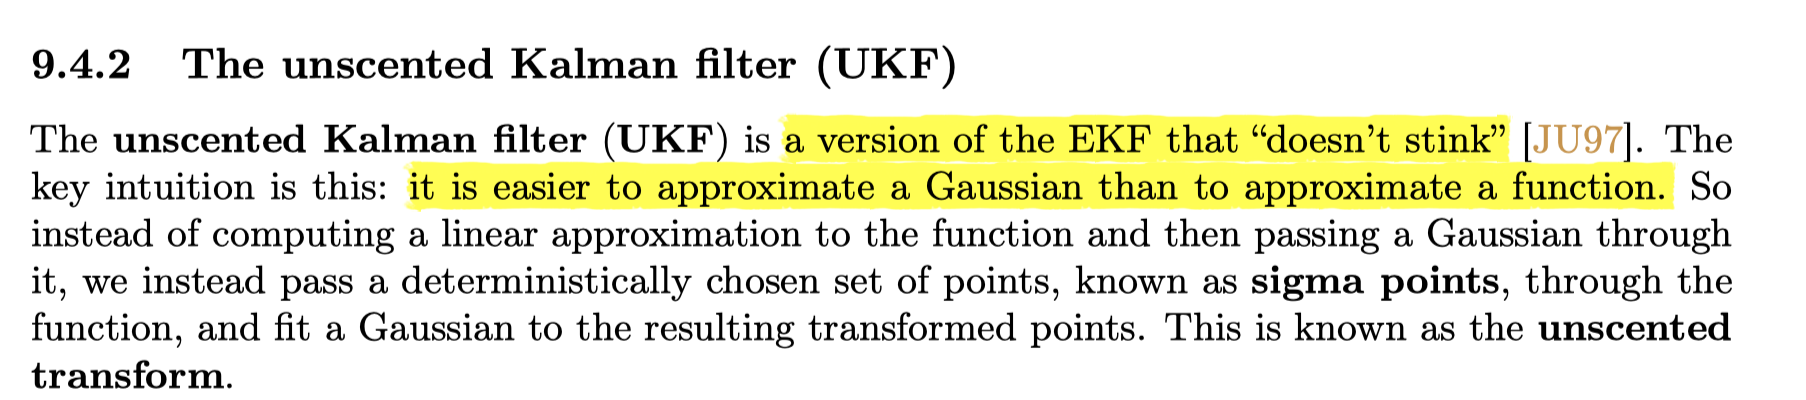

In [57]:
import jax.numpy as jnp
from jax import random
from jax.scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [264]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The uncented transform

### One-dimensional

In [265]:
key = random.PRNGKey(314)
nsamples = 2000
d = 1
μ, σ = 0, 1
x = random.normal(key, (nsamples,)) * σ + μ

<AxesSubplot:ylabel='Count'>

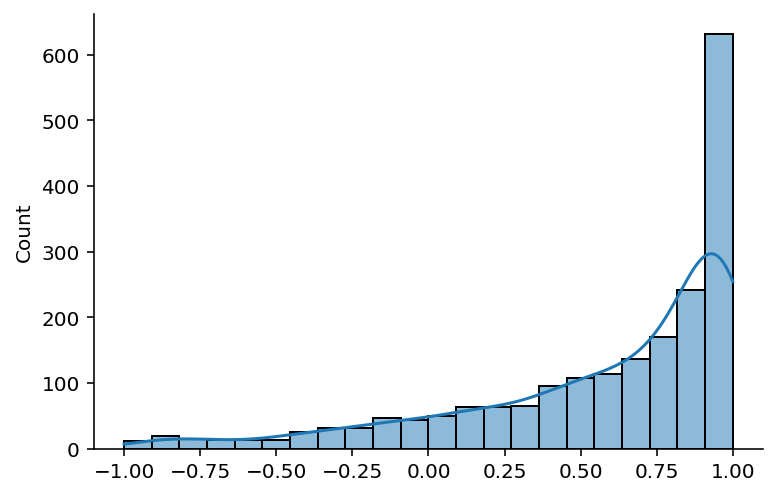

In [266]:
def f(x): return jnp.cos(x)
sns.histplot(f(x), kde=True)

First, we create a set of $2d + 1$ sigma points

In [267]:
α, β, κ = 1, 0, 2
λ = α ** 2 * (d + κ) - d

In [268]:
sigma_points = jnp.array([μ, μ + jnp.sqrt(d + λ) * σ, μ - jnp.sqrt(d + λ) * σ])
sigma_points
y = f(sigma_points)
y

DeviceArray([ 1.        , -0.16055651, -0.16055651], dtype=float32)

In [269]:
wm_0 = λ / (d + λ)
wc_0 = λ / (d + λ) + (1 - α ** 2 + β)

wm_i = wc_i = 1 / (2 * (d + λ))

wm_vec = jnp.asarray([wm_0, wm_i, wm_i])
wc_vec = jnp.asarray([wc_0, wc_i, wc_i])

In [270]:
μy = wm_vec @ y
μy

DeviceArray(0.6131478, dtype=float32)

In [271]:
σy = np.sqrt((y - μy) ** 2 @ wc_vec)
σy

0.5470916

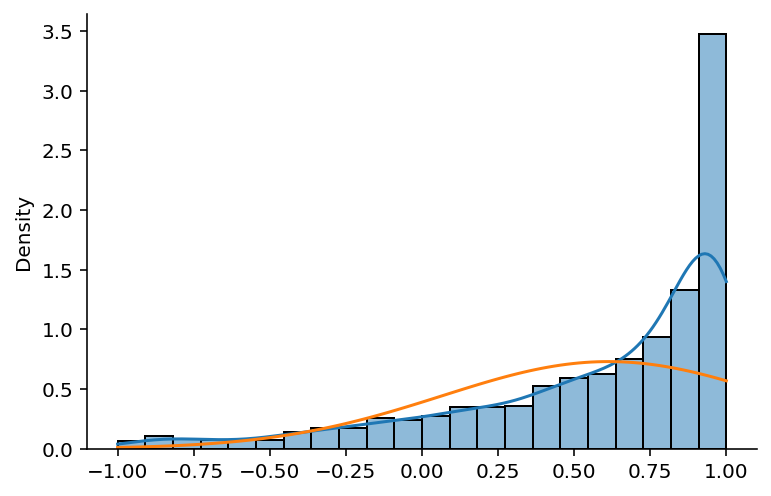

In [272]:
yrange = jnp.linspace(-1, 1, 100)

sns.histplot(f(x), kde=True, stat="density")
plt.plot(yrange, stats.norm.pdf(yrange, loc=μy, scale=σy), c="tab:orange")

### Bidimensional

In [373]:
key = random.PRNGKey(314)
nsamples = 1000
d = 2
μ = jnp.zeros(2)
Σ = jnp.array([[1, 0.5], [0.5, 1]])
x = random.multivariate_normal(key, μ, Σ, (nsamples, ))

In [374]:
α, β, κ = 1, 0, 2
λ = α ** 2 * (d + κ) - d

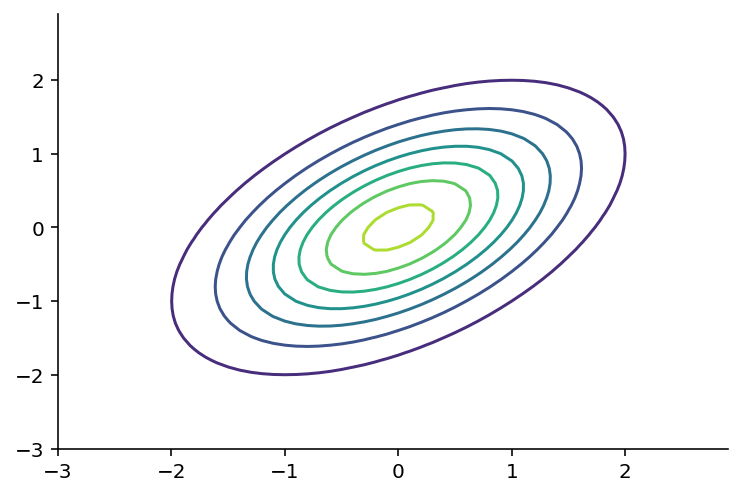

In [375]:
X = jnp.mgrid[-3:3:0.1, -3:3:0.1]
Px = jnp.apply_along_axis(lambda x: stats.multivariate_normal.pdf(x, μ, Σ), 0, X)
plt.contour(*X, Px)

In [376]:
def f(x): return jnp.asarray([x[1], x[0] - x[0] ** 3])

y_samp = f(x.T).T
y_samp.shape

(1000, 2)

<AxesSubplot:>

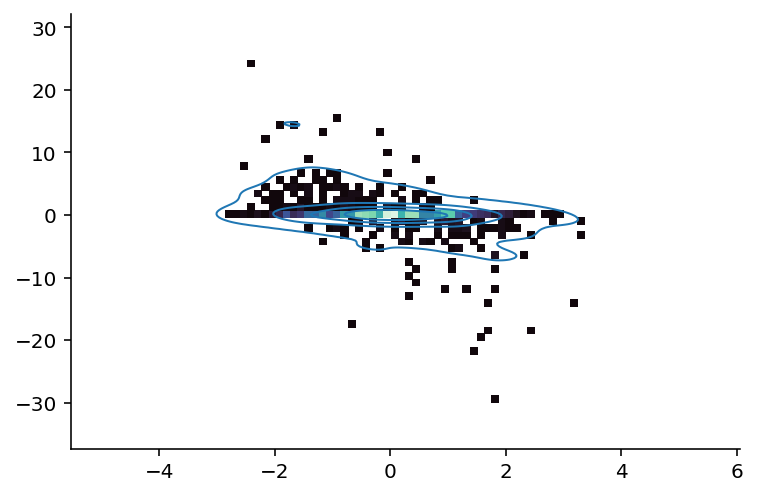

In [377]:
sns.histplot(x=y_samp[:, 0], y=y_samp[:, 1], bins=50, cmap="mako")
sns.kdeplot(x=y_samp[:, 0], y=y_samp[:, 1], levels=5, linewidths=1, cut=8, gridsize=300)

<AxesSubplot:>

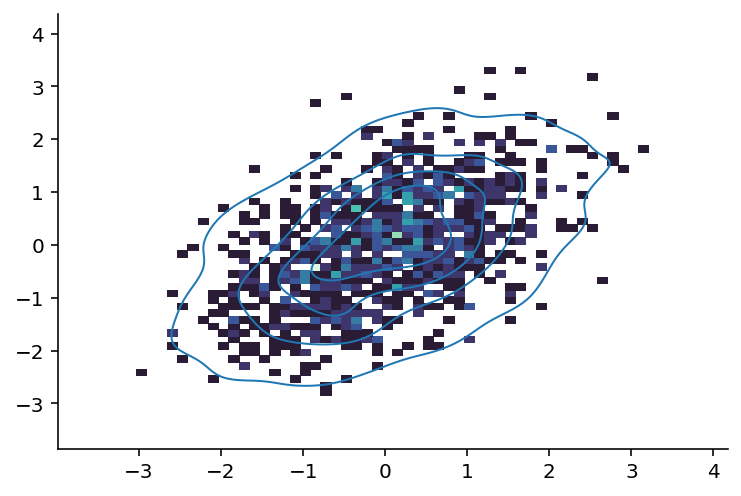

In [378]:
sns.histplot(x=x[:, 0], y=x[:, 1], bins=50, cmap="mako")
sns.kdeplot(x=x[:, 0], y=x[:, 1], levels=5, linewidths=1)

In [379]:
comp1 = μ[:, None] + np.sqrt((d + λ) * Σ)
comp2 = μ[:, None] - np.sqrt((d + λ) * Σ)
sigma_points = jnp.c_[μ, comp1, comp2]
sigma_points

DeviceArray([[ 0.       ,  2.       ,  1.4142135, -2.       , -1.4142135],
             [ 0.       ,  1.4142135,  2.       , -1.4142135, -2.       ]],            dtype=float32)

In [380]:
wm_vec = jnp.array([1 / (2 * (d + λ)) if i > 0 else λ / (d + λ) for i in range(2 * d + 1)])
wc_vec = jnp.array([1 / (2 * (d + λ)) if i > 0 else λ / (d + λ) + (1 - α ** 2 + β) for i in range(2 * d + 1)])

wm_vec.shape

(5,)

In [381]:
y = f(sigma_points)
y.shape

(2, 5)

In [382]:
μy = y @ wm_vec
μy

DeviceArray([0.0000000e+00, 1.4901161e-08], dtype=float32)

In [383]:
dev_Σ = (y - μy[:, None])
Σy = jnp.einsum("i,ji,ki->jk", wm_vec, dev_Σ, dev_Σ)
Σy

DeviceArray([[ 1.5      , -2.8284268],
             [-2.8284268,  9.5      ]], dtype=float32)

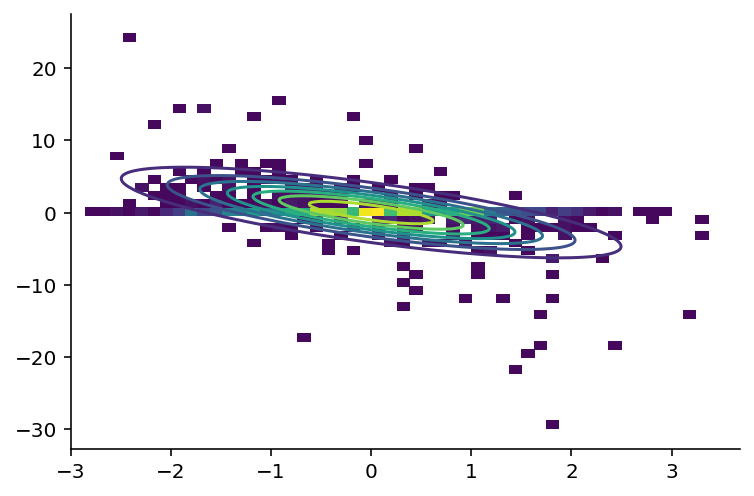

In [384]:
X = jnp.mgrid[-3:3:0.1, -20:20:0.1]
Px = jnp.apply_along_axis(lambda x: stats.multivariate_normal.pdf(x, μy, Σy), 0, X)
sns.histplot(x=y_samp[:, 0], y=y_samp[:, 1], bins=50, cmap="viridis")
plt.contour(*X, Px)